In [127]:
# Source: https://pyimagesearch.com/2020/06/29/opencv-selective-search-for-object-detection/

In [128]:
# !pip uninstall -y opencv-contrib-python opencv-python opencv-python-headless opencv-contrib-python-headless
# !pip install opencv-contrib-python

In [129]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import time
import random
from tensorflow import keras

In [130]:
FAST_METHOD = True
INPUT_SIZE = (224,224)
MIN_PROB = 0.8

In [131]:
def preprocess_image(image, input_size):
    image = cv2.resize(image, input_size)
    image = keras.preprocessing.image.img_to_array(image)
    return [keras.applications.resnet.preprocess_input(image)]

In [132]:
image = cv2.imread("/kaggle/input/dataset-1/LUX7417-1_desktop.jpg")
image = image[...,::-1]
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
ss.setBaseImage(image)

if FAST_METHOD:
    ss.switchToSelectiveSearchFast()
else:
    ss.switchToSelectiveSearchQuality()

In [133]:
start = time.time()
bboxes = ss.process()
end = time.time()

print("[INFO] Selective search took {:.4f} seconds".format(end - start))
print("[Info] {} total regions proposed".format(len(bboxes)))

[INFO] Selective search took 46.8538 seconds
[Info] 7318 total regions proposed


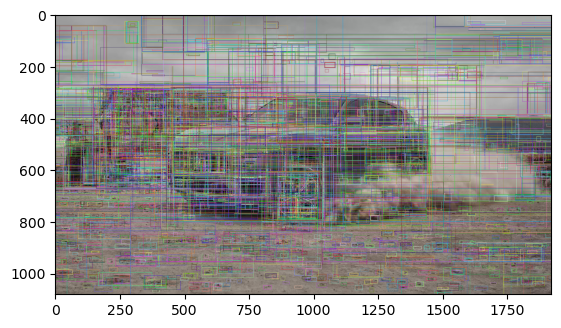

In [134]:
image_copy = image.copy()

for (x, y, w, h) in bboxes:
    color = [random.randint(0, 255) for _ in range(0, 3)]
    cv2.rectangle(image_copy, (x, y), (x+w, y+h), color, 1)
    
plt.imshow(image_copy)

In [135]:
model = keras.applications.ResNet50(weights="imagenet", include_top=True)

In [136]:
start = time.time()

decoded_preds = []
for (x, y, w, h) in bboxes:
    roi = image[y:y+h, x:x+w]
    preprocessed_roi = np.array(preprocess_image(roi, INPUT_SIZE), dtype="float32")
    
    raw_pred = model.predict(preprocessed_roi)
    (_, label, prob) = keras.applications.imagenet_utils.decode_predictions(raw_pred, top=1)[0][0]
    if prob < MIN_PROB:
        continue
    
    formated_pred = {
        "label": label,
        "prob": prob,
        "bbox": (x, y, w, h)
    }
    decoded_preds.append(formated_pred)
    
end = time.time()

print("[INFO] ROIs prediction took {:.4f} seconds".format(end - start))
print("[INFO] {} ROIs where predicted with more than {} of probability".format(len(decoded_preds), MIN_PROB))

1/1 [==============================] - 0s 26ms/step
[INFO] ROIs prediction took 484.4559 seconds
[INFO] 647 ROIs where predicted with more than 0.8 of probability


In [137]:
decoded_preds

[{'label': 'komondor', 'prob': 0.9879996, 'bbox': (489, 866, 59, 16)},
 {'label': 'theater_curtain', 'prob': 0.85595316, 'bbox': (390, 1047, 39, 6)},
 {'label': 'oboe', 'prob': 0.9145047, 'bbox': (716, 521, 30, 11)},
 {'label': 'car_wheel', 'prob': 0.9614866, 'bbox': (886, 545, 202, 246)},
 {'label': 'ski', 'prob': 0.9610335, 'bbox': (924, 690, 20, 19)},
 {'label': 'grille', 'prob': 0.86751294, 'bbox': (436, 507, 443, 120)},
 {'label': 'affenpinscher', 'prob': 0.8494965, 'bbox': (219, 589, 27, 15)},
 {'label': 'grille', 'prob': 0.9969182, 'bbox': (436, 511, 228, 116)},
 {'label': 'nematode', 'prob': 0.96552616, 'bbox': (970, 586, 54, 49)},
 {'label': 'pick', 'prob': 0.820956, 'bbox': (1031, 476, 31, 15)},
 {'label': 'komondor', 'prob': 0.89722216, 'bbox': (736, 854, 84, 29)},
 {'label': 'pick', 'prob': 0.94148237, 'bbox': (568, 607, 96, 20)},
 {'label': 'grille', 'prob': 0.9551571, 'bbox': (458, 512, 196, 89)},
 {'label': 'loudspeaker', 'prob': 0.8159385, 'bbox': (680, 634, 88, 70)},
 

In [138]:
labels = {}
for roi in decoded_preds:
    label = roi["label"]
    (x, y, w, h) = roi["bbox"]
    
    if label not in labels:
        labels[label] = {
            "color": [random.randint(0, 255) for _ in range(0, 3)],
            "bboxes": [],
            "probs": [],
        }
        
    labels[label]["bboxes"].append(roi["bbox"])    
    labels[label]["probs"].append(roi["prob"])   

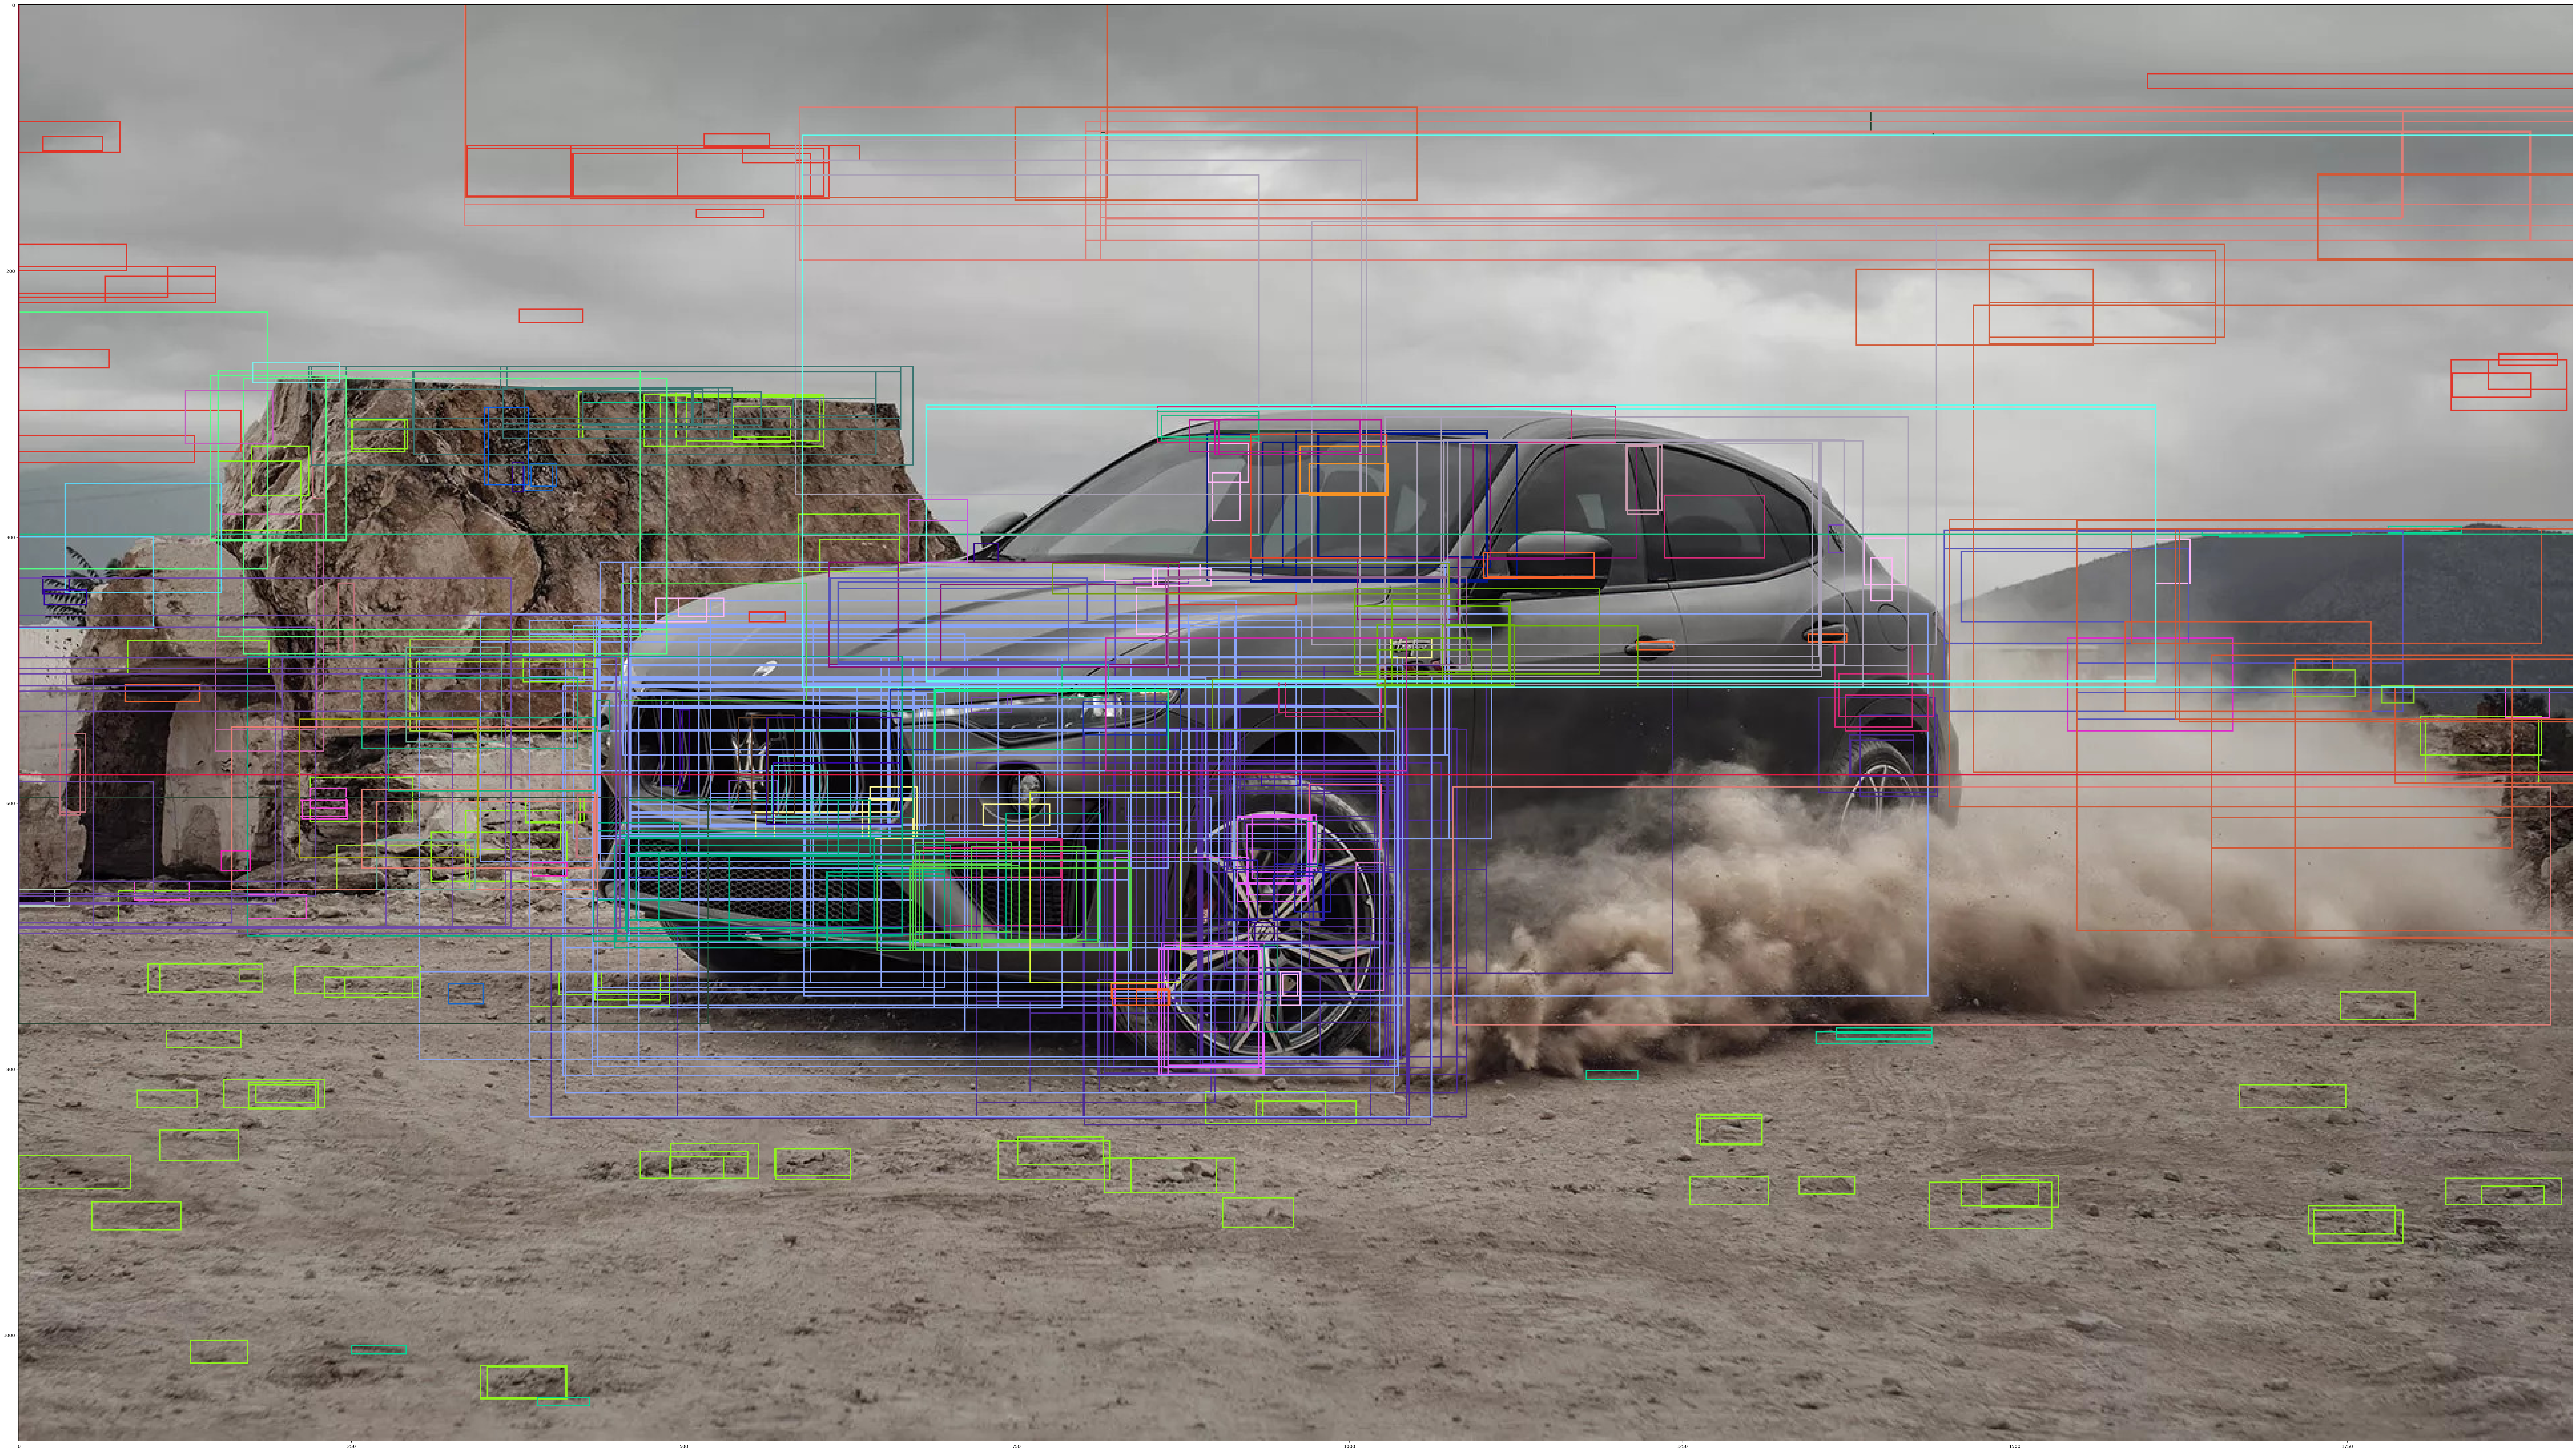

In [150]:
image_copy = image.copy()
for (k, v) in labels.items():
    for (x, y, w, h) in v["bboxes"]:
        cv2.rectangle(image_copy, (x, y), (x+w, y+h), v["color"], 1)
    
# plt.imshow(image_copy)

fig, ax = plt.subplots(figsize=(100, 100))
ax.imshow(image_copy, interpolation='nearest')

plt.show()